In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#check GPU (optional)
!nvidia-smi

Mon Mar 28 07:43:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tt
import torch.optim as optim
from torchsummary import summary

ROOT_PATH = '/content/drive/MyDrive/QMUL/NN/code/nn_group5'
sys.path.append(ROOT_PATH)
from my_module import functions as myf
from my_module import make_dataset as mds
model_path = '/content/drive/MyDrive/QMUL/NN/code/model_para/'

myf.torch_fix_seed()

In [ ]:
#get dataloader
train_transform = tt.Compose(
    [tt.ToTensor(),
     tt.RandomHorizontalFlip(),
     tt.RandomRotation(30)])
validation_transform = tt.Compose(
    [tt.ToTensor()])

train_dl = mds.get_dl(
    data='training', 
    bs=64, 
    shuffle=True, 
    transform=train_transform
)
validation_dl = mds.get_dl(
    data='validation', 
    bs=64, 
    shuffle=False, 
    transform=validation_transform
)
dev = "cuda" if torch.cuda.is_available() else "cpu"

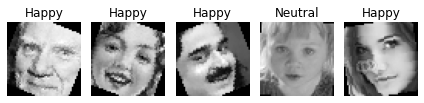

In [ ]:
#check some samples
dict_classes={
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprised',
    6: 'Neutral'
  }
fig, axes = plt.subplots(1, 5, tight_layout=True)
for i in range(5):
    img, label = train_dl.dataset[np.random.randint(0,10000)]
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(dict_classes[label])


In [ ]:
class Block(nn.Module):
    def __init__(self, channel):
        super().__init__()
        
        self.conv1 = nn.Conv2d(channel, channel,
                               kernel_size=(3, 3),
                               stride=1,
                               padding=1)
        self.bn1 = nn.BatchNorm2d(channel)
        self.gelu = nn.GELU()
        
        self.conv2 = nn.Conv2d(channel, channel,
                               kernel_size=(3, 3),
                               stride=1,
                               padding=1)
        self.bn2 = nn.BatchNorm2d(channel)
        
        self.shortcut = self._shortcut(channel, channel)
        
    def forward(self, x):
        h = self.conv1(x)
        h = self.bn1(h)
        h = self.gelu(h)
        h = self.conv2(h)
        h = self.bn2(h)
        
        shortcut = self.shortcut(x)
        y = self.gelu(h + shortcut)  # skip connection
        return y
    def _shortcut(self, channel_in, channel_out):
        if channel_in != channel_out:
            return self._projection(channel_in, channel_out)
        else:
            return lambda x: x
    def _projection(self, channel_in, channel_out):
        return nn.Conv2d(channel_in, channel_out,
                         kernel_size=(1, 1),
                         padding=0)

In [ ]:
class GlobalAvgPool2d(nn.Module):
    def __init__(self,
                 device=dev):
        super().__init__()

    def forward(self, x):
        return F.avg_pool2d(x, kernel_size=x.size()[2:]).view(-1, x.size(1))

In [ ]:
class ResNet34(nn.Module):
    def __init__(self, output_dim):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 64,
                               kernel_size=3,
                               padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        # Block 1
        self.block1 = nn.ModuleList([
            self._building_block(64) for _ in range(3)
        ])

        self.conv2 = nn.Conv2d(64, 128,
                               kernel_size=(1, 1),
                               stride=(2, 2))

        # Block 2
        self.block2 = nn.ModuleList([
            self._building_block(128) for _ in range(4)
        ])

        self.conv3 = nn.Conv2d(128, 256,
                               kernel_size=(1, 1),
                               stride=(2, 2))

        # Block 3
        self.block3 = nn.ModuleList([
            self._building_block(256) for _ in range(6)
        ])

        self.conv4 = nn.Conv2d(256, 512,
                               kernel_size=(1, 1),
                               stride=(2, 2))

        # Block 4
        self.block4 = nn.ModuleList([
            self._building_block(512) for _ in range(3)
        ])

        self.avg_pool = GlobalAvgPool2d()
        self.fc = nn.Linear(512, 1000)
        self.gelu = nn.GELU()
        self.out = nn.Linear(1000, output_dim)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        h = self.conv1(x)
        h = self.bn1(h)
        for block in self.block1:
            h = block(h)
        h = self.conv2(h)
        for block in self.block2:
            h = block(h)
        h = self.conv3(h)
        for block in self.block3:
            h = block(h)
        h = self.conv4(h)
        for block in self.block4:
            h = block(h)
        h = self.avg_pool(h)
        h = self.fc(h)
        h = self.dropout(h)
        h = self.gelu(h)
        h = self.out(h)

        return h

    def _building_block(self,
                        channel):
        return Block(channel)

In [ ]:
model = ResNet34(7).to(dev)
optimizer = optim.AdamW(model.parameters(), weight_decay=1e-4)
train_loss = myf.LabelSmoothingCrossEntropy()
train_func = myf.mixup_train_loop
epochs = 100

train_acc, val_acc = myf.mixup_ls_fit(
    model,
    optimizer,
    epochs,
    train_dl,
    validation_dl,
    train_func=train_func
    train_loss=train_loss
    print_loss=True
)
torch.save(model.state_dict(), model_path + 'ResNet34.pth')

Epoch 1
loss: 1.872957  [ 6336/28709]
loss: 1.855562  [12736/28709]
loss: 1.743659  [19136/28709]
loss: 1.826441  [25536/28709]
Train accuracy: 24.9% 
Val accuracy  : 27.5%
-------------------------------
Epoch 2
loss: 1.759554  [ 6336/28709]
loss: 1.829536  [12736/28709]
loss: 1.881097  [19136/28709]
loss: 1.782422  [25536/28709]
Train accuracy: 26.9% 
Val accuracy  : 30.3%
-------------------------------
Epoch 3
loss: 1.723877  [ 6336/28709]
loss: 1.898621  [12736/28709]
loss: 1.755038  [19136/28709]
loss: 1.722513  [25536/28709]
Train accuracy: 31.9% 
Val accuracy  : 37.5%
-------------------------------
Epoch 4
loss: 1.797341  [ 6336/28709]
loss: 1.663009  [12736/28709]
loss: 1.631419  [19136/28709]
loss: 1.671398  [25536/28709]
Train accuracy: 34.8% 
Val accuracy  : 39.2%
-------------------------------
Epoch 5
loss: 1.633874  [ 6336/28709]
loss: 1.668114  [12736/28709]
loss: 1.725916  [19136/28709]
loss: 1.707971  [25536/28709]
Train accuracy: 37.7% 
Val accuracy  : 48.0%
-------

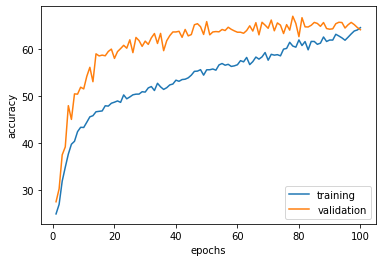

In [ ]:
myf.plot_acc(
    train_acc,
    val_acc, 
    epochs, 
    savefig=True, 
    name='ResNet34_acc')

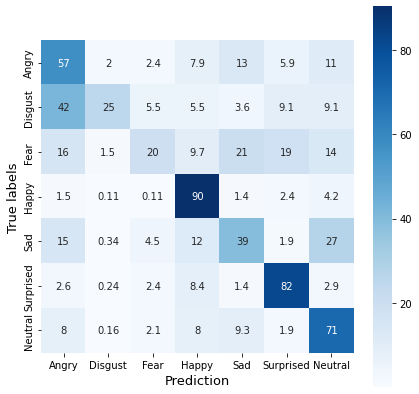

In [ ]:
myf.plot_cfmat(
    model, 
    validation_dl, 
    dict_classes, 
    savefig=True, 
    name='ResNet34_cfmat')